<a href="https://colab.research.google.com/github/nyp-sit/iti107-2024s2/blob/main/session-3/yolo8_custom_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using YOLO

Welcome to this week's hands-on lab. In this lab, we are going to learn how to train a balloon detector!

At the end of this exercise, you will be able to:

- create an object detection dataset in YOLO format
- fine-tune a YOLOv8 pretrained model with the custom dataset
- monitor the training progress and evaluation metrics
- deploy the trained model for object detection

## Create an object detection dataset

We will use a sample balloon dataset to illustrate the process of annotation and packaging the dataset into different format for object detection (e.g. YOLO, Pascal VOC, COCO, etc).

To annotate, there are many different tools available, such as the very basic [LabelImg](https://github.com/HumanSignal/labelImg) , or the more feature-packed tool such as [Label Studio](https://labelstud.io/), or online service such as [Roboflow](https://roboflow.com/).

### Raw Image Dataset

You can download the balloon images (without annotations) from this link:

https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_raw_dataset.zip

Unzip the file to a local folder.

There are total of 74 images. You should divide the images into both training and validation set (e.g. 80%-20%, i.e. 59 images for train, and 15 for test).


### Option 1: Label Studio

You can follow the [steps](https://labelstud.io/guide/quick_start) here to setup Label Studio on your PC. It is recommended to setup a conda environment before you install the Label Studio.  

Here are the steps that need to be done:
1. Create a new Project
2. Import the images into Label Studio
3. Set up the Labelling UI tempalte (choose Object Detection with Bounding Box template)
4. Export the dataset in YOLO format.

The exported dataset will have the following folder structure:
```
<root folder>
classes.txt    --> contains the labels, with each class label on a new line
--images --> contains the images
--labels --> contains the annotations (i.e. bbox coordinates)
notes.json --> some info about this dataset (i.e. not used)
```

For training with YOLOv8 (from Ultralytics), you need to organize the files into `train` and `validate` (and optionally `test`) folders, and to create a `data.yaml` file to provide information about the folder location of test and validation set:

```
<root folder>
--train
----images
----labels
--valid
----images
----labels
data.yaml
```

The data.yaml file should specify the following:
```
train: ../train/images
val: ../valid/images
test: ../test/images

names:
    0: balloon
```

If you have more than one class of object to detect, specify the rest of the names under the names field.


## Option 2: Roboflow

Alternatively, you can use the online service Roboflow to do annotation. Roboflow integrates very well with Ultralytics and you can easily export the dataset in a format recognized by Ultralytics trainer (for YOLO model)

You can create a new account with [Roboflow](https://roboflow.com/).

Similarly, you can create a new project, upload all the raw images, annotate them and then export.

You can choose the format to be YOLOv8 and choose local directory to download the dataset locally instead of pushing it to the Roboflow universal wish.

Here is a [introductory blog](https://blog.roboflow.com/getting-started-with-roboflow/) on using the Roboflow to annotate.





## Auto Labelling using Grounding DINO

Both Label Studio and Roboflow supports the use of Grounding DINO to auto label the dataset.

[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is open-set object detector, marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs (prompts) such as category names or referring expressions.

### Using Grounding DINO with Label Studio

You can follow the instruction [here](https://labelstud.io/blog/using-text-prompts-for-image-annotation-with-grounding-dino-and-label-studio/)  to setup the Grounding DINO ML backend to integrate with your label studio.

### Using Grounding DINO with Roboflow

Here is a [video tutorial](https://youtu.be/SDV6Gz0suAk) on using Grounding DINO with Roboflow.


### Download Annotated Dataset

To save you time for this lab, you can download a pre-annotated balloon dataset [here](https://github.com/nyp-sit/iti107-2024S2/raw/refs/heads/main/data/balloon_annotated_dataset.zip).

We download and unzip to the directory called `datasets`



In [ ]:
%%capture
%%bash
wget https://github.com/thmasquerade07/SpecialistDiploma_Repository/raw/c3e6ac76ecf193667d7f0a5d226111a6296845d6/SDip%20Applied%20AI/PDC2_Applied%20AI/ITI107_Assign/gym_annotated_dataset.zip
mkdir -p datasets
unzip gym_annotated_dataset.zip -d datasets/

In [ ]:
%%capture
!pip install ultralytics
!pip install comet_ml

## Training the Model

YOLOv8 comes with different sizes of pretrained models: yolov8n, yolov8s, .... They differs in terms of their sizes, inference speeds and mean average precision:

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/yolo-models.png?raw=true" width="70%"/>


We will use the small pretrained model yolo8s and finetune it on our custom dataset.

Note: n-nano, s-small, m-medium, l-large, x-xtra large

Note: in terms of performance, larger models better than smaller (look at mAP val 50-95)

Note: in terms of speed, smaller models faster than larger (look at speed CPU ONNX)


### Setup the logging

Ultralytics support logging to `wandb`, `comet.ml` and `tensorboard`, out of the box. Here we only enable wandb.

You need to create an account at [`wandb`](https://wandb.ai) and get the API key from https://wandb.ai/authorize.


In [ ]:
from ultralytics import settings

settings.update({"wandb": True, #enable weights & biases logging
#                 "comet.ml": False,
                 "tensorboard": False}) #disable tensorboard logging

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Training

We specify the path to `data.yaml` file, and train with a batch size of 15, and we also save the checkpoint at each epoch (save_period=1). We assume here you are connected to a GPU, hence we can specify the device to use as `device=0` to select the first GPU.  We specify the project name as `balloon`, this will create a folder called `balloon` to store the weights and various training artifacts such as F1, PR curves, confusion matrics, training results (loss, mAP, etc).

For a complete listing of train settings, you can see [here](https://docs.ultralytics.com/modes/train/#train-settings).

You can also specify the type of data [augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters)  you want as part of the train pipeline.

You can monitor your training progress at wandb (the link is given in the train output below)


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/data.yaml",
                     epochs=30,
                     save_period=1,
                     batch=16,
                     device='cpu',
                     #device=0, #note: if don't have GPU, need to change device=0 to device='cpu'
                     project='mygymproject',
                     plots=True)

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cpu, workers=8, project=mygymproject, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 14.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/datasets/train/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 594.90it/s]

train: New cache created: /content/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 2636.01it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to mygymproject/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to mygymproject/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.117      3.741      1.784        102        640: 100%|██████████| 3/3 [02:17<00:00, 45.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.25s/it]

                   all         19        108     0.0928     0.0476     0.0518     0.0224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.717      2.555      1.538        133        640: 100%|██████████| 3/3 [01:58<00:00, 39.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.93s/it]

                   all         19        108      0.317      0.398      0.332        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G       1.56       1.75      1.329        136        640: 100%|██████████| 3/3 [01:57<00:00, 39.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.36s/it]

                   all         19        108      0.544      0.489      0.487      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G       1.38      1.538      1.272        185        640: 100%|██████████| 3/3 [01:58<00:00, 39.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.93s/it]

                   all         19        108      0.573      0.565       0.53      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.292       1.41      1.201        122        640: 100%|██████████| 3/3 [01:53<00:00, 37.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:16<00:00, 16.21s/it]

                   all         19        108      0.547      0.593      0.557      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.259      1.289      1.199        152        640: 100%|██████████| 3/3 [01:50<00:00, 36.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.66s/it]

                   all         19        108      0.514      0.583      0.531      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.263      1.193      1.155        213        640: 100%|██████████| 3/3 [01:48<00:00, 36.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.57s/it]

                   all         19        108      0.551      0.595      0.609      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G      1.133      1.083      1.103        106        640: 100%|██████████| 3/3 [01:50<00:00, 36.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.81s/it]

                   all         19        108      0.516      0.625      0.611      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G       1.23      1.116      1.146        134        640: 100%|██████████| 3/3 [01:49<00:00, 36.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.60s/it]

                   all         19        108      0.652      0.612      0.677      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.198      1.021       1.13        144        640: 100%|██████████| 3/3 [01:52<00:00, 37.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.75s/it]

                   all         19        108      0.701      0.568       0.68      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.241     0.9576      1.132        195        640: 100%|██████████| 3/3 [01:49<00:00, 36.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.55s/it]

                   all         19        108      0.499      0.733      0.646      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G       1.36       1.07      1.223        148        640: 100%|██████████| 3/3 [01:48<00:00, 36.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]

                   all         19        108      0.608      0.616      0.642      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.284      0.993        1.2        106        640: 100%|██████████| 3/3 [01:53<00:00, 37.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.69s/it]

                   all         19        108      0.628      0.724      0.696       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.243     0.9928      1.109        138        640: 100%|██████████| 3/3 [01:49<00:00, 36.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]

                   all         19        108       0.68      0.734      0.699      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.168     0.9742       1.12        106        640: 100%|██████████| 3/3 [01:52<00:00, 37.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.76s/it]

                   all         19        108      0.612      0.693      0.653      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.265      1.019      1.211        160        640: 100%|██████████| 3/3 [01:50<00:00, 36.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.77s/it]

                   all         19        108      0.599      0.711      0.648      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G       1.27     0.9875      1.237         98        640: 100%|██████████| 3/3 [01:47<00:00, 35.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.51s/it]

                   all         19        108      0.689       0.69       0.72      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.242     0.9389      1.152        121        640: 100%|██████████| 3/3 [01:47<00:00, 35.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.58s/it]

                   all         19        108      0.672      0.693       0.74       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G      1.207      0.903      1.147        189        640: 100%|██████████| 3/3 [01:48<00:00, 36.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.59s/it]

                   all         19        108      0.703      0.728       0.74      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.181      0.817      1.085        192        640: 100%|██████████| 3/3 [01:48<00:00, 36.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.68s/it]

                   all         19        108      0.706      0.748       0.74      0.489


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G      1.183     0.8731      1.157        104        640: 100%|██████████| 3/3 [01:46<00:00, 35.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]

                   all         19        108      0.649      0.771      0.729      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G      1.163     0.8333      1.151         73        640: 100%|██████████| 3/3 [01:45<00:00, 35.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.34s/it]

                   all         19        108      0.621      0.805      0.721      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      1.107     0.7896      1.069         77        640: 100%|██████████| 3/3 [01:46<00:00, 35.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.55s/it]

                   all         19        108       0.66      0.804      0.731      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G      1.171     0.7716      1.113        104        640: 100%|██████████| 3/3 [01:46<00:00, 35.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.75s/it]

                   all         19        108      0.672       0.76      0.716       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      1.118     0.7414       1.09         78        640: 100%|██████████| 3/3 [01:51<00:00, 37.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]

                   all         19        108      0.671      0.751      0.694      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G      1.097     0.6724      1.126         99        640: 100%|██████████| 3/3 [01:47<00:00, 35.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.66s/it]

                   all         19        108      0.647      0.764      0.695      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      1.107     0.6509      1.085        116        640: 100%|██████████| 3/3 [01:48<00:00, 36.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.41s/it]

                   all         19        108      0.728      0.727      0.704       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G      1.133     0.6367      1.066        114        640: 100%|██████████| 3/3 [01:48<00:00, 36.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:15<00:00, 15.80s/it]

                   all         19        108      0.724      0.729      0.712      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G      1.132     0.6566      1.081         98        640: 100%|██████████| 3/3 [01:48<00:00, 36.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.66s/it]

                   all         19        108      0.724      0.729      0.712      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G      1.086     0.6418      1.083        137        640: 100%|██████████| 3/3 [01:47<00:00, 35.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:17<00:00, 17.44s/it]

                   all         19        108      0.742      0.737      0.733      0.507



30 epochs completed in 1.069 hours.
Optimizer stripped from mygymproject/train/weights/last.pt, 22.5MB
Optimizer stripped from mygymproject/train/weights/best.pt, 22.5MB

Validating mygymproject/train/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


                   all         19        108       0.73      0.747      0.732      0.507
               dumbell         19         84      0.577      0.619      0.567      0.328
            whiteboard         19         24      0.882      0.875      0.897      0.686
Speed: 2.6ms preprocess, 730.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to mygymproject/train


lr/pg0,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
lr/pg1,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
lr/pg2,▁▂▃▄▄▅▆▆▇▇▇████████▇▇▇▆▆▅▅▄▃▂▂
metrics/mAP50(B),▁▄▅▆▆▆▇▇▇▇▇▇██▇▇██████████████
metrics/mAP50-95(B),▁▄▅▆▆▆▇▇▇█▇▇▇▇▇▇███████▇▇▇████
metrics/precision(B),▁▃▆▆▆▆▆▆▇█▅▇▇▇▇▇█▇██▇▇▇▇▇▇████
metrics/recall(B),▁▄▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇██████▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▃▂▂▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-metrics.png?raw=true"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti107-2024S2/blob/main/assets/wandb-loss.png?raw=true"/>

You can go to the folder `balloon-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.88` for `mAP50`, and `0.78` for `mAP50-95`.

In [ ]:
from ultralytics import YOLO

model = YOLO("mygymproject/train/weights/best.pt")
#validation_results = model.val(data="datasets/data.yaml", device="0")
validation_results = model.val(data="datasets/data.yaml", device="cpu")

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.99s/it]


                   all         19        108       0.73      0.747      0.732      0.507
               dumbell         19         84      0.577      0.619      0.567      0.328
            whiteboard         19         24      0.882      0.875      0.897      0.686
Speed: 10.6ms preprocess, 817.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val


## Fine Tuning Process

### Scenario 1 - Increase Training Time & Adjust Learning Rate Decay
Changes:

*   Increase epoch: since precision, recall & mAP metrics are steadily increasing. the model may not have fully converged. increasing the number of epoch gives the model more time to learn.
*   Adjust lrf (Learning Rate Final): a smaller final learning rate allows the model to converge more smoothly towards the end of training.

Rationale:


*   Increasing epochs allows the model to train longer & capture more complex patterns in the dataset.
*   A smaller lrf ensures the model does not overshoot or under-optimize in later epochs, leading to better fine-tuning.




In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(
    data="datasets/data.yaml",
    epochs=50,           # Increase epochs to 50
    save_period=2,
    batch=16,            # Keep batch size the same
    optimizer='SGD',     # Keep optimizer as SGD (default)
    cos_lr=True,         # Use cosine learning rate scheduling
    lr0=0.01,            # Keep initial learning rate the same
    lrf=0.0001,          # Reduce final learning rate to allow smooth convergence
    device=0,
    project='mygymproject',
    plots=True
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 103MB/s] 


Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=2, cache=False, device=0, workers=8, project=mygymproject, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 95.5MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 1692.92it/s]

train: New cache created: /content/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/valid/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 804.47it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to mygymproject/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to mygymproject/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.64G       2.02      3.566      1.723        186        640: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         19        108     0.0504     0.0536     0.0327     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.66G      2.019      3.674      1.772        120        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         19        108     0.0545     0.0536     0.0362     0.0156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.92G      1.981      3.437      1.667        138        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         19        108     0.0767     0.0595       0.05     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       3.7G      1.882      3.003      1.602        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         19        108      0.136      0.185      0.105     0.0438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.68G      1.644      2.401      1.419        114        640: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         19        108       0.12      0.342       0.15     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.9G      1.671      1.867      1.413        172        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         19        108      0.297      0.369      0.214      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.85G      1.488      1.735      1.343        152        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         19        108      0.331      0.521      0.386      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.88G      1.377      1.512      1.282        202        640: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         19        108      0.492      0.515      0.457      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.01G      1.428      1.509      1.297        115        640: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         19        108      0.664      0.404      0.503      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.89G      1.397       1.31      1.224        137        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         19        108      0.618      0.488      0.583      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.99G       1.34      1.342      1.241        168        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         19        108      0.566      0.601      0.583      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.83G      1.391      1.187      1.228        197        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         19        108      0.695      0.585      0.623      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.98G      1.374      1.187      1.232        102        640: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         19        108      0.712      0.595      0.609      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.92G      1.352      1.172      1.232         96        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         19        108      0.575      0.624      0.652      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.9G      1.266      1.165      1.201        171        640: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         19        108      0.634       0.59      0.632      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.79G      1.269      1.113      1.205        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         19        108      0.587      0.638      0.677      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.01G      1.309      0.961      1.107        183        640: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         19        108      0.494      0.518      0.477      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.92G      1.224      1.072      1.161        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         19        108      0.465        0.5      0.518      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.9G      1.168      1.052      1.137        156        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all         19        108      0.632      0.672      0.698      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.95G       1.18     0.9845      1.163        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         19        108      0.743      0.604      0.733      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.79G      1.202      1.068      1.168        156        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         19        108      0.777      0.641      0.723      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.94G       1.27     0.9433       1.19        203        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         19        108      0.808      0.545      0.702      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.94G      1.161     0.9656      1.142        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         19        108      0.693      0.685       0.73      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.81G      1.222     0.9494      1.149        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         19        108      0.685      0.657      0.724      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.95G      1.206     0.8819      1.128        164        640: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         19        108      0.633      0.639      0.685      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.94G      1.146     0.8391      1.126        143        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         19        108      0.771      0.526      0.674      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.89G      1.082     0.8287      1.069         93        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         19        108        0.8      0.554      0.695      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.86G      1.182     0.7707      1.147        196        640: 100%|██████████| 3/3 [00:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         19        108      0.717      0.604       0.68      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.79G      1.153     0.7834        1.1        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         19        108      0.717      0.604       0.68      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.9G      1.085     0.7754      1.065        115        640: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         19        108      0.794      0.607      0.728      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.96G      1.064     0.7737      1.063        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         19        108      0.785      0.623      0.749      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.01G       1.03     0.7641      1.066        155        640: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         19        108      0.721      0.789      0.781      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.87G      1.109     0.7032       1.05        145        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         19        108      0.721      0.789      0.781      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.76G      1.024     0.6583      1.061        103        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         19        108      0.714      0.738      0.762      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.76G      1.061     0.6293      1.048        192        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         19        108      0.765      0.649      0.762      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.73G      1.029     0.6548      1.074         94        640: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         19        108      0.802      0.684      0.758      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.94G      1.116     0.6545      1.076        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         19        108      0.802      0.684      0.758      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.91G      1.084     0.6753      1.097        137        640: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19        108      0.721      0.756      0.783      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.71G      1.071     0.6253      1.052        189        640: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19        108      0.743      0.661      0.718      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.93G       0.99     0.6232       1.04        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         19        108      0.732      0.682      0.743      0.508


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.78G      1.133     0.7164      1.059        102        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         19        108      0.732      0.682      0.743      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.84G      1.136       0.64       1.11        110        640: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         19        108      0.729      0.651      0.714      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.8G      1.127     0.6615      1.057         83        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         19        108      0.781      0.667      0.716      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.8G      1.123     0.6176      1.076        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         19        108      0.772      0.643      0.717      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.81G      1.105     0.5844      1.082         94        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         19        108      0.772      0.643      0.717      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.97G      1.072     0.5953      1.061        126        640: 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         19        108      0.822       0.64      0.732      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.98G      1.044     0.6407      1.066         77        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         19        108      0.791      0.688      0.766      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.01G     0.9914      0.577      1.044         56        640: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         19        108      0.792      0.699      0.779      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.82G      1.119     0.6215      1.064        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         19        108      0.792      0.699      0.779      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.97G      1.044     0.5987      1.023         77        640: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         19        108      0.798      0.685       0.77       0.52



50 epochs completed in 0.030 hours.
Optimizer stripped from mygymproject/train/weights/last.pt, 22.5MB
Optimizer stripped from mygymproject/train/weights/best.pt, 22.5MB

Validating mygymproject/train/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         19        108      0.723      0.789       0.78      0.543
               dumbell         19         84      0.673      0.702      0.703      0.409
            whiteboard         19         24      0.772      0.875      0.856      0.676
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to mygymproject/train


lr/pg0,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▁▂▂▃▃▄▅▅▆▆▇▇▇▇████████▇▇▇▆▆▆▅▅▄▃▃▂▂▂▁▁▁▁
lr/pg2,▁▂▂▃▃▄▅▅▆▆▇▇▇▇███████▇▇▇▇▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁
metrics/mAP50(B),▁▁▁▂▂▄▅▅▆▆▆▇▇▇▅▇█▇▇█▇▇▇▇▇█████████▇▇████
metrics/mAP50-95(B),▁▁▁▁▂▄▅▅▆▆▇▇▇▅▆▇█▇██▇▇▇▇████▇▇▇██▇▇▇▇███
metrics/precision(B),▁▁▁▂▂▄▅▇▆▆▇▆▆▆▅▆▇█▇▇██▇▇█▇▇▇▇█▇▇▇▇█████▇
metrics/recall(B),▁▁▁▂▄▅▅▄▅▆▆▆▆▇▅▇▆▇▆▇▇▆▆▆▆██▇▇▇▇▇▇▇▇▇▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,███▇▅▄▄▄▄▃▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▂▂▂▂▂▁▁


In [ ]:
from ultralytics import YOLO

model = YOLO("mygymproject/train/weights/best.pt")
validation_results = model.val(data="datasets/data.yaml", device="0")

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


                   all         19        108      0.722      0.789      0.779      0.542
               dumbell         19         84      0.673      0.702      0.703      0.409
            whiteboard         19         24      0.772      0.875      0.856      0.675
Speed: 0.3ms preprocess, 21.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


### Scenario 2 - Increase Batch Size & Use a Larger Initial Learning Rate
Changes:


*   Increase batch: a larger batch size helps stabalize gradient updates, leading to better generalization, especially for small datasets.
*   Increase lr0 (Initial Learning Rate): a larger initial learning rate enables faster convergence in earlier epochs.
*   Switch Optimizer to AdamW: AdamW combines the benefits of Adam with weight decay regularization, which often improves generalization.



Rationale:


*   A larger batch size reduces noise in gradient updates & helps stabalize the optimization process.
*   A higher initial learning rate enables faster convergence at the start of training, especially with AdamW, which is more resilient to larger learning rates.
*   Keeping lrf slightly higher ensures the model does not reduce learning too early, given the higher initial rate.


In [ ]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolov8s.pt")  # Load a pre-trained YOLO model
result = model.train(
    data="datasets/data.yaml",
    epochs=30,           # Keep the same number of epochs
    save_period=1,
    batch=32,            # Increase batch size to 32
    optimizer='AdamW',   # Switch to AdamW optimizer
    cos_lr=True,         # Use cosine learning rate scheduling
    lr0=0.02,            # Increase initial learning rate
    lrf=0.001,           # Keep final learning rate higher than Scenario 1
    device=0,
    project='mygymproject',
    plots=True
)


Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/data.yaml, epochs=30, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=8, project=mygymproject, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/datasets/train/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]


Plotting labels to mygymproject/train3/labels.jpg... 
optimizer: AdamW(lr=0.02, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to mygymproject/train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.33G       2.08      3.357      1.727        165        640: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         19        108      0.054     0.0536     0.0319     0.0114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.23G      2.051      3.564      1.705        107        640: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19        108      0.046     0.0536     0.0327     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.11G      2.008      3.541      1.699        104        640: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         19        108    0.00802      0.551    0.00811    0.00393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.15G      2.111      5.552      1.781         99        640: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         19        108     0.0103      0.438     0.0115    0.00571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.52G      2.041      5.839      1.769        105        640: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         19        108    0.00106     0.0714   0.000676   0.000204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.72G      2.715      6.955      2.188        207        640: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         19        108   0.000764     0.0417   0.000393   9.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.58G      3.095      5.077      2.407        179        640: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       7.6G      3.129      3.766      2.371        221        640: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       7.5G      2.872      3.278      2.446        161        640: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.52G      2.588      2.978      2.282        132        640: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.62G       2.55      2.624      2.152        202        640: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.52G      2.588      2.734      2.235        124        640: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.63G      2.444      2.572      2.194        133        640: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.53G      2.447      2.549      2.182        169        640: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.48G      2.319       2.39      2.091        148        640: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.49G      2.432      2.492      2.288        110        640: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.48G      2.319      2.454      2.084        167        640: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.54G      2.238       2.49      2.097        100        640: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.31G      2.295      2.238      2.088        188        640: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.25G      2.197      2.246      2.055        111        640: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       7.2G      2.132      2.181       1.95         79        640: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.19G      2.134      2.129      1.961        103        640: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.19G      2.166      2.121      1.975         78        640: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.36G       2.09      2.069      1.901        104        640: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.18G      2.031      1.962      1.886        118        640: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.21G       2.06      1.954      1.899        112        640: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       7.2G      2.015      1.906      1.856        104        640: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.22G      2.058       1.88      1.861        137        640: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.21G      2.067      2.005      1.912         90        640: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.37G      2.037      1.895      1.853        152        640: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         19        108   0.000203     0.0119    9.3e-05   1.38e-05



30 epochs completed in 0.025 hours.
Optimizer stripped from mygymproject/train3/weights/last.pt, 22.5MB
Optimizer stripped from mygymproject/train3/weights/best.pt, 22.5MB

Validating mygymproject/train3/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         19        108     0.0463     0.0536     0.0326      0.013
               dumbell         19         84     0.0926      0.107     0.0524     0.0214
            whiteboard         19         24          0          0     0.0129    0.00455
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to mygymproject/train3


lr/pg0,███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▁▂▃▄▅▅▆▇▇▇██████▇▇▆▆▅▅▄▄▃▂▂▂▁▁
lr/pg2,▁▂▃▄▅▅▆▇▇▇██████▇▇▆▆▅▅▄▄▃▂▂▂▁▁
metrics/mAP50(B),██▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
metrics/mAP50-95(B),▇█▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
metrics/precision(B),█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇
metrics/recall(B),▂▂█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▁▁▁▂▁▅██▆▅▄▅▄▄▃▄▃▂▃▂▂▂▂▂▁▁▁▁▁▁


In [ ]:
from ultralytics import YOLO

model = YOLO("mygymproject/train/weights/best.pt")
validation_results = model.val(data="datasets/data.yaml", device="0")
#validation_results = model.val(data="datasets/data.yaml", device="cpu")

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/valid/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


                   all         19        108     0.0464     0.0536     0.0325     0.0129
               dumbell         19         84     0.0927      0.107     0.0521     0.0214
            whiteboard         19         24          0          0     0.0129    0.00454
Speed: 0.3ms preprocess, 23.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val2


## Export and Deployment

Your model is in pytorch format (.pt). You can export the model to various format, e.g. TorchScript, ONNX, OpenVINO, TensorRT, etc. depending on your use case, and deployment platform (e.g. CPU or GPU, etc)

You can see the list of [supported formats](https://docs.ultralytics.com/modes/export/#export-formats)  and the option they support in terms of further optimization (such as imagesize, int8, half-precision, etc) in the ultralytics site.

Ultralytics provide a utility function to benchmark your model using different supported formats automatically. You can uncomment the code in the following code cell to see the benchmark result. If you are benchmarking for CPU only, the change the `device=0` to `device='cpu'`.  

**Beware: it will take quite a while to complete the benchmark**

In [ ]:
# from ultralytics.utils.benchmarks import benchmark

# # Benchmark on GPU (device=0 means the 1st GPU device)
# benchmark(model="balloon/train/weights/best.pt", data="datasets/data.yaml", imgsz=640, half=False, device=0)


In the following code, we export it as OpenVINO. OpenVINO is optimized for inference on Intel CPUs and since we will use the model later on to do inference on local Windows machine (which runs Intel chip), we will export it as OpenVINO format. We also specify using int8 quantization, which results in faster inference, at the cost of accuracy.

For more information on OpenVINO, go to the [official documentation](https://docs.openvino.ai/2024/index.html).

After export, you can find the openvino model in `balloon\train\weights\best_openvino_model` directory.

In [ ]:
model = YOLO("mygymproject/train/weights/best.pt")
exported_path = model.export(format="openvino", int8=True)

Ultralytics 8.3.56 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ INT8 export requires a missing 'data' arg for calibration. Using default 'data=coco8.yaml'.
Model summary (fused): 168 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'mygymproject/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)
requirements: Ultralytics requirement ['openvino>=2024.5.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 209.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.9s, installed 1 package: ['openvino>=2024.5.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.6.0-17404-4c0f47d2335-releases/2024/6...
requirements: Ultralytics requirement ['nncf>=2.14.0'] not found, attempting AutoUpdate...
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py):

100%|██████████| 433k/433k [00:00<00:00, 17.2MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 3236.45file/s]

Dataset download success ✅ (0.9s), saved to /content/datasets




Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 811.71it/s]

New cache created: /content/datasets/coco8/labels/val.cache
OpenVINO: WARNING ⚠️ >300 images recommended for INT8 calibration, found 4 images.


INFO:nncf:16 ignored nodes were found by patterns in the NNCFGraph
INFO:nncf:1 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 161 __module.model.22.dfl/aten::view/Reshape
INFO:nncf:Not adding activation input quantizer for operation: 162 __module.model.22/aten::sigmoid/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 172 __module.model.22.dfl/aten::transpose/Transpose
INFO:nncf:Not adding activation input quantizer for operation: 181 __module.model.22.dfl/aten::softmax/Softmax
INFO:nncf:Not adding activation input quantizer for operation: 190 __module.model.22.dfl.conv/aten::_convolution/Convolution
INFO:nncf:Not adding activation input quantizer for operation: 197 __module.model.22.dfl/aten::view/Reshape_1
INFO:nncf:Not adding activation input quantizer for operation: 209 __module.model.22/aten::sub/Subtract
INFO:nncf:Not adding activation input quantizer for operation: 210 __module.model.22/aten:

Output()

Output()

OpenVINO: export success ✅ 38.7s, saved as 'mygymproject/train/weights/best_int8_openvino_model/' (11.2 MB)

Export complete (41.1s)
Results saved to /content/mygymproject/train/weights
Predict:         yolo predict task=detect model=mygymproject/train/weights/best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=mygymproject/train/weights/best_int8_openvino_model imgsz=640 data=datasets/data.yaml int8 
Visualize:       https://netron.app


## Inference

Let's test our model on some sample pictures. You can optionally specify the confidence threshold (e.g. `conf=0.5`), and the IoU (e.g. `iou=0.6`) for the NMS. The model will only output the bounding boxes of those detection that exceeds the confidence threshould and the IoU threshold.  

Loading mygymproject/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...



100%|██████████| 94.4k/94.4k [00:00<00:00, 8.41MB/s]


image 1/1 /content/gym_photo.jpg: 640x640 1 dumbell, 1 whiteboard, 190.2ms
Speed: 5.7ms preprocess, 190.2ms inference, 16.3ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'dumbell', 1: 'whiteboard'}
obb: None
orig_img: array([[[186, 192, 191],
        [186, 192, 191],
        [186, 192, 191],
        ...,
        [212, 217, 218],
        [212, 217, 218],
        [212, 217, 218]],

       [[186, 192, 191],
        [186, 192, 191],
        [186, 192, 191],
        ...,
        [212, 217, 218],
        [212, 217, 218],
        [212, 217, 218]],

       [[186, 192, 191],
        [186, 192, 191],
        [186, 192, 191],
        ...,
        [212, 217, 218],
        [212, 217, 218],
        [212, 217, 218]],

       ...,

       [[ 68,  73,  72],
        [ 69,  74,  73],
        [ 67,  72,  71],
        ...,
        [203, 198, 197],
        [19

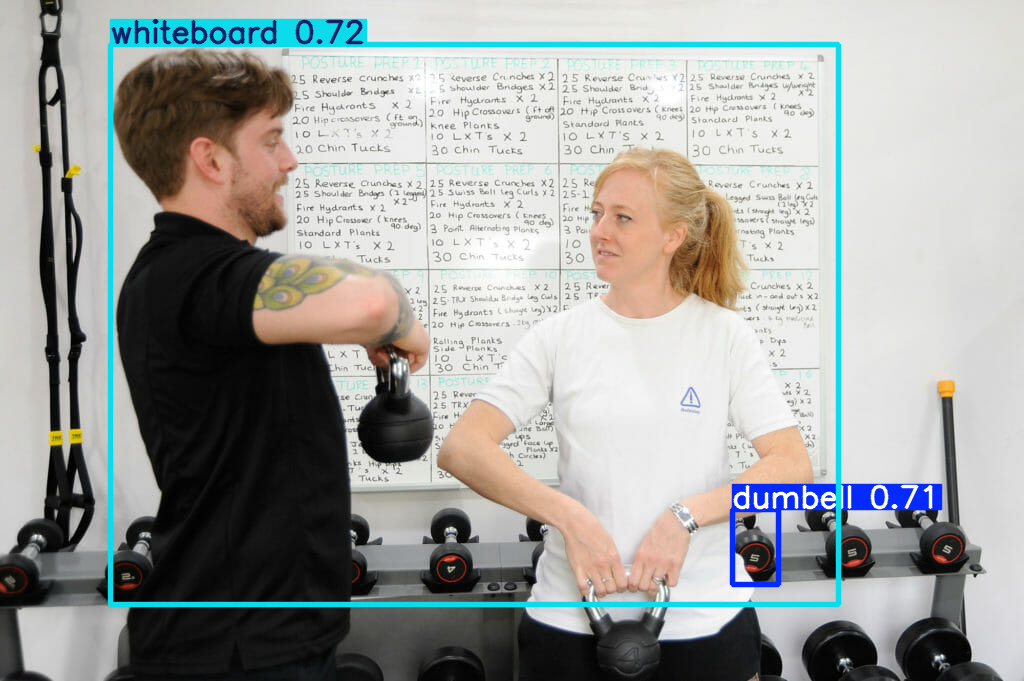

In [ ]:
import ultralytics
from ultralytics import YOLO
from PIL import Image

#source = 'https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/sample_balloon.jpeg'
source = 'https://raw.github.com/thmasquerade07/SpecialistDiploma_Repository/16a8cac21026771c78e5e3b92f82edc1c5d129cf/SDip%20Applied%20AI/PDC2_Applied%20AI/ITI107_Assign/gym_photo.jpg'
#source = './samples/sample_balloon.jpeg'
model = YOLO("mygymproject/train/weights/best_int8_openvino_model", task='detect')
result = model(source, conf=0.5, iou=0.6)
#note: if have lots of duplicates = decrease iou (FYI: any that is more than iou value is considered as duplicate)
#note: if have lots of false detections = increase conf (conf=confidence)

# Visualize the results
for i, r in enumerate(result):
    print(r)
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image for matplotlib need to reverse the order of the channel located at last index

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"results{i}.jpg")

## Download the Model

If you are training your model on Google Colab, you will download the exported OpenVINO model to a local PC. If you are training your model locally, then the exported model should already be on your local PC.

Run the following code to zip up the OpenVINO folder and download to local PC.

*Note: If you encountered error message "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968", uncomment the following cell and run it.*


In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%bash
mv ./mygymproject/train/weights/best_int8_openvino_model/ .
zip -r best_int8_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

  adding: best_int8_openvino_model/ (stored 0%)
  adding: best_int8_openvino_model/best.xml (deflated 95%)
  adding: best_int8_openvino_model/best.bin (deflated 18%)
  adding: best_int8_openvino_model/metadata.yaml (deflated 32%)


## Streaming

We can also do real-time detection on a video or camera steram.

The code below uses openCV library to display video in a window, and can only be run locally on a local laptop.




### Video File

You need `OpenCV` to run the following code.  In your conda environment, install `opencv` for python using the following command:

```
pip3 install opencv-python
```
or
```
conda install opencv
```

Let's donwload the sample video file.

In [ ]:
#!wget https://raw.githubusercontent.com/nyp-sit/iti107-2024S2/refs/heads/main/session-3/samples/balloon.mp4

In [ ]:
# manually upload mp4 video into gdrive

### Streaming and display video

In [ ]:
# @title streaming FYI(skip)
from ultralytics import YOLO
import cv2

# Load the YOLO model
model = YOLO("best_int8_openvino_model", task="detect")

# Open the video file
video_path = "balloon.mp4"
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLO inference on the frame on GPU Device 0
        results = model(frame, device="cpu")

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLO Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

### Detect and write to a video file

In [ ]:
from ultralytics import YOLO
import cv2
# from tqdm import tqdm
from tqdm.auto import tqdm

def write_video(video_in_filepath, video_out_filepath, model):
    # Open the video file

    video_reader = cv2.VideoCapture(video_in_filepath)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    video_writer = cv2.VideoWriter(video_out_filepath,
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps,
                            (frame_w, frame_h))

    # Loop through the video frames
    for i in tqdm(range(nb_frames)):
        # Read a frame from the video
        success, frame = video_reader.read()

        if success:
            # Run YOLO inference on the frame on GPU Device 0
            results = model(frame, conf=0.9, device=0)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Write the annotated frame
            video_writer.write(annotated_frame)

    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


In [ ]:
from pathlib import Path
import os

video_in_file = "gym_video.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected' + '.mp4')
model = YOLO("best_int8_openvino_model", task="detect")
write_video(video_in_file, video_out_file, model)

  0%|          | 0/1770 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 640x640 (no detections), 180.4ms
Speed: 3.0ms preprocess, 180.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 187.2ms
Speed: 3.1ms preprocess, 187.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 200.4ms
Speed: 3.0ms preprocess, 200.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 179.4ms
Speed: 3.0ms preprocess, 179.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 183.4ms
Speed: 2.9ms preprocess, 183.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 178.4ms
Speed: 2.7ms preprocess, 178.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 186.6ms
Speed: 2.8ms preprocess, 186.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 6

In [ ]:
#then download gym_video_detected.mp4